# Hextraj tutorial

We'll learn how to

- [x] create a projection
- [ ] label positions along a trajectory
- [ ] aggregate data within the labelled hexagons
- [ ] calculate a connectivity matrix for the hexagons

## Imports

In [1]:
from hextraj import HexProj

import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from dask.distributed import Client

In [2]:
dask_client = Client(n_workers=1, threads_per_worker=4)
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 7.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39835,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:41285,Total threads: 4
Dashboard: http://127.0.0.1:40427/status,Memory: 7.77 GiB
Nanny: tcp://127.0.0.1:42059,


## The HexProj object

By default, it uses the [Lambert Azimuthal Equal-Area Projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) centered about a location `(lon_origin, lat_origin)`, which needs to be specified by the user.
It also uses a hex size in meters (which is the distance of the corners from the center of the hex), and defaults to a "flat top" orientation of the hexed.

For details, check
```python
HexProj?
```

## Load some trajectories

There's an example dataset included in the repo here. It covers the North-Sea region and has 19-day-long trajectories with one timestep / day.

In [3]:
ds_traj = xr.open_dataset("../data/trajs/nwshelf.nc", chunks={"traj": 500, "obs": -1})
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(500, 20), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

## A hex projector

We need a good center longitude and latitude and a good size of the hexes.
The height (North-South) of the flat hexes is $\sqrt{3}\cdot{\rm size}$.

In [4]:
hex_proj = HexProj(
    lon_origin=(ds_traj.lon.min() + ds_traj.lon.max()).compute().data[()] / 2,  # center lon
    lat_origin=(ds_traj.lat.min() + ds_traj.lat.max()).compute().data[()] / 2,  # center lat
    hex_size_meters=(  # have 70 hexes in meridional direction
        (ds_traj.lat.max() - ds_traj.lat.min()).compute().data[()]
        * 111e3 / 20 / (3 ** 0.5)
    ),
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
hex_proj.proj

<Other Coordinate Operation Transformer: laea>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

## Hex labels for each position

In [6]:
%%time

hex_labels = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    ds_traj.lon, 
    ds_traj.lat,
    dask="parallelized",
    output_dtypes=[tuple, ],
)

# hex_labels = hex_labels.compute()

CPU times: user 4.45 ms, sys: 385 µs, total: 4.84 ms
Wall time: 4.84 ms


In [7]:
hex_labels

<xarray.DataArray (traj: 5000, obs: 20)>
dask.array<transpose, shape=(5000, 20), dtype=object, chunksize=(500, 20), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, obs

In [8]:
ds_traj["hex_labels"] = hex_labels
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(500, 20), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(500, 20), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    hex_labels   (traj, obs) object dask.array<chunksize=(500, 20), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

## Hex heat maps

In [9]:
from dask import array as darr

In [10]:
unique_labels =  xr.DataArray(darr.from_array(np.unique(ds_traj["hex_labels"]), chunks=(600, )), dims=("hex", ))
unique_labels

<xarray.DataArray 'array-9b094ac061ff1316187fbe2820944f45' (hex: 353)>
dask.array<array, shape=(353,), dtype=object, chunksize=(353,), chunktype=numpy.ndarray>
Dimensions without coordinates: hex

In [11]:
from hextraj.aux import hex_AoS_to_SoA

In [12]:
_lon, _lat = hex_proj.hex_to_lon_lat_SoA(hex_AoS_to_SoA(unique_labels.data.compute()))

In [13]:
ds_agg = (ds_traj["hex_labels"] == unique_labels).sum(["traj"])
ds_agg

<xarray.DataArray (obs: 20, hex: 353)>
dask.array<sum-aggregate, shape=(20, 353), dtype=int64, chunksize=(20, 353), chunktype=numpy.ndarray>
Dimensions without coordinates: obs, hex

In [14]:
import cartopy
from matplotlib import pyplot as plt

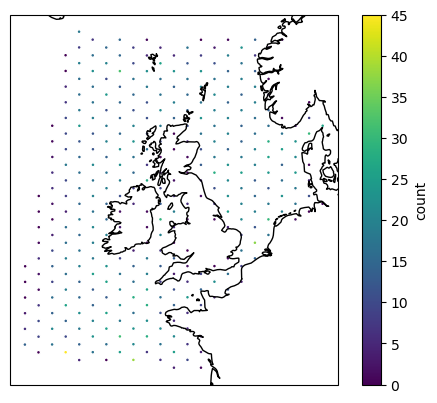

In [15]:
fig, ax = plt.subplots(1, 1, subplot_kw={
    "projection": cartopy.crs.Stereographic(
        central_latitude=hex_proj.lat_origin,
        central_longitude=hex_proj.lon_origin,
    ),
})

(
    ds_agg
    .assign_coords(lon=("hex", _lon), lat=("hex", _lat))
    .compute()
    .isel(hex=slice(1, None))
).to_dataset(name="count").isel(obs=-1).plot.scatter(x="lon", y="lat", s=8, hue="count", ax=ax, transform=cartopy.crs.PlateCarree())
ax.coastlines()

In [16]:
conn_mat = (
    (ds_traj.isel(obs=0, drop=True).hex_labels == unique_labels.rename({"hex": "hex0"}))
    & (ds_traj.isel(obs=-1, drop=True).hex_labels == unique_labels)
).sum(["traj"])
conn_mat

<xarray.DataArray (hex0: 353, hex: 353)>
dask.array<sum-aggregate, shape=(353, 353), dtype=int64, chunksize=(353, 353), chunktype=numpy.ndarray>
Dimensions without coordinates: hex0, hex

In [17]:
%%time

conn_mat = conn_mat.compute()

CPU times: user 219 ms, sys: 25.3 ms, total: 245 ms
Wall time: 998 ms


In [18]:
import networkx

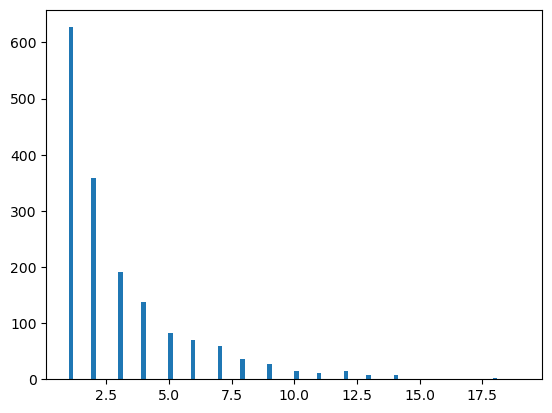

In [19]:
conn_mat.where(conn_mat > 0).plot.hist(bins=100);

In [20]:
conn_mat = conn_mat / conn_mat.sum("hex0")

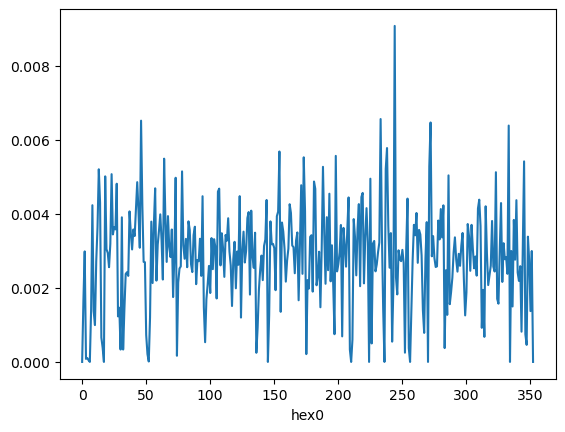

In [21]:
conn_mat.mean("hex").plot()

In [22]:
adjmat = (conn_mat > 0).astype(int).data
adjmat

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
g = networkx.DiGraph(adjmat[:, :])

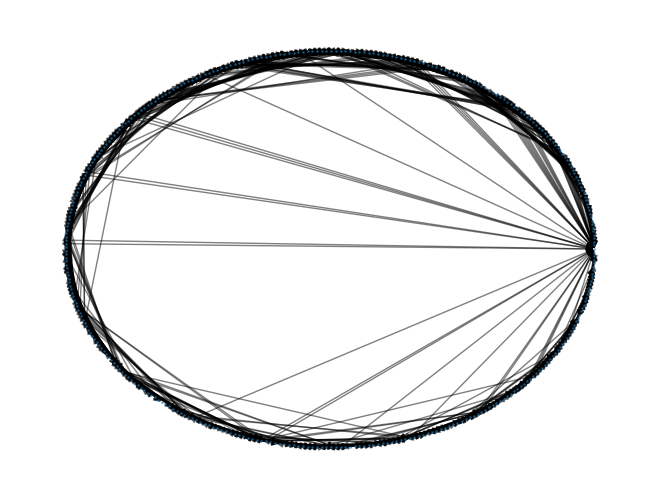

In [24]:
g.remove_edges_from(networkx.selfloop_edges(g))
networkx.draw_circular(g, node_size=1, alpha=0.5)

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/crs.py:405: RuntimeWarning: invalid value encountered in remainder
  x[to_180] = (((x[to_180] + 180) % 360) - 180)


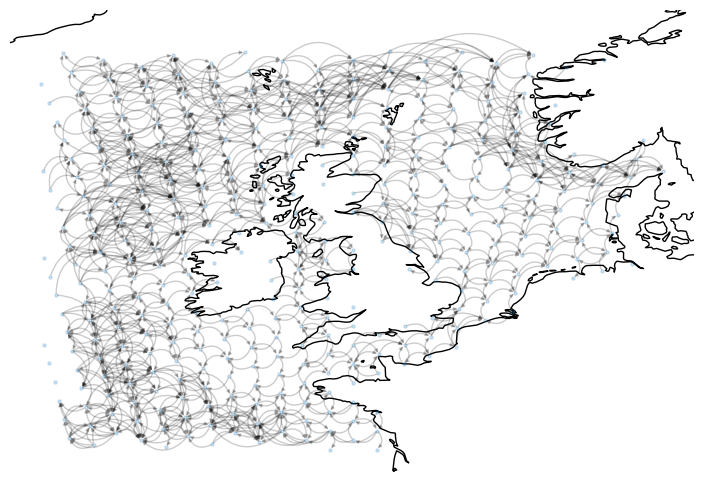

In [25]:
fig, ax = plt.subplots(
    1, 1, 
    subplot_kw={
    "projection": cartopy.crs.PlateCarree(),
        # "projection": cartopy.crs.Stereographic(
        #     central_latitude=hex_proj.lat_origin,
        #     central_longitude=hex_proj.lon_origin,
        # ),
    },
    figsize=(10, 6),
)

# networkx.draw_networkx_edges(
networkx.draw(
    g, pos={n: pos for n, pos in enumerate(zip(_lon[:], _lat[:]))}, node_size=5, arrowsize=5, alpha=0.2, ax=ax,
    connectionstyle="arc3,rad=-0.5"
);
ax.coastlines()